In [417]:
import numpy as np
import pandas as pd

In [418]:
from utils.data_funcs import *

In [419]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [420]:
import time

In [421]:
import matplotlib.pyplot as plt

# Get raw input data for LSTM model

In [263]:
# Get state policy data
input_df = get_state_policy_data(fill=True)

# Keep relevant columns
policy_of_interest = POLICIES[0]
input_df = input_df[['region_name', 'date', policy_of_interest]]

/home/beau/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3338: DtypeWarning: Columns (2,3) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [264]:
# Rename region_name to state
input_df.rename(columns={'region_name': 'state'}, inplace=True)

# Get US daily case data for 50 states
us_state_daily = get_state_covid_daily_data()
not_states = ['District of Columbia', 'Guam', 'Northern Mariana Islands','Puerto Rico', 'Virgin Islands']
us_state_daily_50 =  us_state_daily[~(us_state_daily.state.isin(not_states))]

In [265]:
# Merge daily cases with input df
input_df = us_state_daily_50.merge(input_df, how='left', on=['state', 'date']).dropna().reset_index(drop=True)

# Get cumulative cases and add as col to input df
input_df['yesterdays_active_cases'] = get_yesterdays_active_cases(input_df, window=1)

# Merge pop density with input df
input_df = input_df.merge(get_pop_density_by_state_data(), on='state', how='left')

# Merge wage data with input df
input_df = input_df.merge(get_scaled_wages_data()[['state', 'scaled_median_income']], on=['state'], how='left')

# Merge political data with input df
input_df = input_df.merge(get_political_data(), on=['state'], how='left')

# Function to convert raw data to format needed for LSTM

In [266]:
def create_dataset (input_df, time_steps = 7):
    temp = input_df
    e_xs, e_ys , d_xs, d_ys = [], [], [], []
    for name_df, df in input_df.groupby(['state']):
        y = df['cases'].to_numpy()
        X = df.drop(columns=['state', 'deaths', 'date', 'cases']).to_numpy()
        for i in range(len(X)-time_steps):
            if (i < len(X) - (time_steps * 2)):
                e_v = X[i:i+time_steps, :]
                e_xs.append(e_v)
                e_ys.append(y[i+time_steps])

                d_v = X[(i+time_steps):(i+(time_steps*2)), 0:2]
                d_xs.append(d_v)
                d_ys.append(y[(i+(time_steps*2))])
            
    return np.array(e_xs), np.array(e_ys), np.array(d_xs), np.array(d_ys)

In [267]:
# Grab time window to split training and test data
date_start = "2020-01-01"
date_end = "2020-12-31"
train_df = input_df.loc[(input_df['date'] >= date_start) & 
                        (input_df['date'] <= date_end)].copy().reset_index(drop=True)
test_df = input_df.loc[(input_df['date'] > date_end)].copy().reset_index(drop=True)

# Get input and output for training
e_x_train_np, e_y_train_np, d_x_train_np, d_y_train_np = create_dataset(train_df)

# Get input and output for testing
e_x_test_np, e_y_test_np, d_x_test_np, d_y_test_np = create_dataset(test_df)

In [413]:
a = [1,2,3,4,5]

In [416]:
a[2]

3

# Define Dual Purpose Encoder/Decoder Model Class

In [243]:
class ED_LSTM(tf.keras.Model):
    def __init__(self, hidden_dim):
        super(ED_LSTM, self).__init__()
        self.hidden_dim = hidden_dim

        # Define the RNN layer, LSTM
        self.lstm = tf.keras.layers.LSTM(
            hidden_dim, return_state=True)
        self.dense = tf.keras.layers.Dense(1)
        
    def call(self, input_sequence, states):
        # Call the LSTM unit
        lstm_out, state_h, state_c = self.lstm(input_sequence, initial_state=states)
        # Dense layer to predict output token
        output = self.dense(lstm_out)
        
        return output, state_h, state_c

    def init_states(self, batch_size):
        # Return a all 0s initial states
        return (tf.zeros([batch_size, self.hidden_dim]),
                tf.zeros([batch_size, self.hidden_dim]))

# Training Functions for LSTM encoder

In [244]:
def encoder_train_step(input_seq, target, en_initial_states, optimizer):
    ''' A training step, train a batch of the data and return the loss value reached
        Input:
        - input_seq: array of integers, shape [batch_size, seq_len, num_features].
            the input sequence
        - target_seq_out: array of integers, shape [batch_size, max_seq_len, 1].
            the target seq, our target sequence
        - target_seq_in: array of integers, shape [batch_size, max_seq_len, 1].
            the input sequence to the decoder, we use Teacher Forcing
        - en_initial_states: tuple of arrays of shape [batch_size, hidden_dim].
            the initial state of the encoder
        - optimizer: a tf.keras.optimizers.
        Output:
        - loss: loss value
        
    '''
    # Network’s computations need to be put under tf.GradientTape() to keep track of gradients
    with tf.GradientTape() as tape:
        # Get the encoder outputs
        en_outputs = encoder(input_seq, en_initial_states)
        output = en_outputs[0]
        # Calculate the loss function
        loss_fun = keras.losses.MeanSquaredError()
        loss = loss_fun(target, output)

    variables = encoder.trainable_variables
    # Calculate the gradients for the variables
    gradients = tape.gradient(loss, variables)
    # Apply the gradients and update the optimizer
    optimizer.apply_gradients(zip(gradients, variables))

    return loss

In [245]:
def encoder_train(encoder, dataset, n_epochs, batch_size, optimizer):
    losses = []

    X = dataset[0]
    y = dataset[1]
    for e in range(n_epochs):
        # Get the initial time
        start = time.time()
        # Get the initial state for the encoder
        en_initial_states = encoder.init_states(batch_size)
        # Generate a random ordering for the data
        perm = np.random.permutation(range(0, len(X)))
        X = X[perm]
        y = y[perm]
        # For every batch data
        for i in range(0, len(X), batch_size):
            if i + batch_size >= len(X):
                en_initial_states = encoder.init_states((len(X) - i))
                input_seq = tf.constant(X[i:(len(X))])
                target = tf.reshape(tf.constant(y[i:(len(X))]), ((len(X) - i), 1))
            else:
                input_seq = tf.constant(X[i:i+batch_size])
                target = tf.reshape(tf.constant(y[i:i+batch_size]), (batch_size, 1))
                
            # Train and get the loss value 
            loss = encoder_train_step(input_seq, target, en_initial_states, optimizer)
        
            if i % 1000 == 0:
                # Store the loss and accuracy values
                losses.append(loss)
                print('Epoch {} Batch {} Loss {:.4f}'.format(e + 1, i, loss.numpy()))
    
        print('Time taken for 1 epoch {:.4f} sec\n'.format(time.time() - start))
        
    return losses

# Define Encoder LSTM model

For the encoder LSTM, we will train on input sequences where each sequence represents a set of consecutive days, and each day will be represented by a set of features corresponding to that day (e.g. yesterday's daily case number, political index, policy strictness, etc.). After the model is trained via minimizing mean squared error or mean absolute error, we will do a run through all the training data so as to capture the hidden state and cell state of the encoder LSTM after being fed a particular sequence. These hidden states and cell states will be used to initialize the encoder LSTM.

In [194]:
encoder = ED_LSTM(100)

In [195]:
losses = encoder_train(encoder, [e_x_train_np, e_y_train_np], 100, 32, keras.optimizers.Adam())


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 1 Batch 0 Loss 32313.9590
Epoch 1 Batch 4000 Loss 804171.7500
Epoch 1 Batch 8000 Loss 929572.1250
Epoch 1 Batch 12000 Loss 4058788.5000
Time taken for 1 epoch 6.9394 sec

Epoch 2 Batch 0 Loss 22409.6113
Epoch 2 Batch 4000 Loss 743684.2500
Epoch 2 Batch 8000 Loss 880279.6250
Epoch 2 Batch 12000 Loss 3968513.0000
Time taken for 1 epoch 6.6509 sec

Epoch 3 Batch 0 Loss 17497.5430
Epoch 3 Batch 4000 Loss 706827.2500
Epoch 3 Batch 8000 Loss 840823.5000
Epoch 3 Batch 12000 Loss 3885023.5000
Time taken f

Time taken for 1 epoch 6.7807 sec

Epoch 43 Batch 0 Loss 5329.7974
Epoch 43 Batch 4000 Loss 61556.4062
Epoch 43 Batch 8000 Loss 75982.0000
Epoch 43 Batch 12000 Loss 1658918.7500
Time taken for 1 epoch 6.7046 sec

Epoch 44 Batch 0 Loss 5196.9375
Epoch 44 Batch 4000 Loss 54397.4961
Epoch 44 Batch 8000 Loss 70662.7188
Epoch 44 Batch 12000 Loss 1620983.5000
Time taken for 1 epoch 6.4416 sec

Epoch 45 Batch 0 Loss 4940.8921
Epoch 45 Batch 4000 Loss 55542.3164
Epoch 45 Batch 8000 Loss 64826.6172
Epoch 45 Batch 12000 Loss 1583821.1250
Time taken for 1 epoch 6.4084 sec

Epoch 46 Batch 0 Loss 4977.0791
Epoch 46 Batch 4000 Loss 56221.2969
Epoch 46 Batch 8000 Loss 61162.4531
Epoch 46 Batch 12000 Loss 1547408.5000
Time taken for 1 epoch 6.4302 sec

Epoch 47 Batch 0 Loss 4979.5527
Epoch 47 Batch 4000 Loss 55767.4844
Epoch 47 Batch 8000 Loss 57212.4297
Epoch 47 Batch 12000 Loss 1511654.7500
Time taken for 1 epoch 6.3673 sec

Epoch 48 Batch 0 Loss 5138.8511
Epoch 48 Batch 4000 Loss 55385.7656
Epoch 4

Epoch 89 Batch 4000 Loss 69592.8281
Epoch 89 Batch 8000 Loss 45532.7500
Epoch 89 Batch 12000 Loss 550317.8125
Time taken for 1 epoch 6.4118 sec

Epoch 90 Batch 0 Loss 5559.5635
Epoch 90 Batch 4000 Loss 146158.9844
Epoch 90 Batch 8000 Loss 48431.3711
Epoch 90 Batch 12000 Loss 532128.1250
Time taken for 1 epoch 6.4602 sec

Epoch 91 Batch 0 Loss 4978.5459
Epoch 91 Batch 4000 Loss 148680.7500
Epoch 91 Batch 8000 Loss 48876.1211
Epoch 91 Batch 12000 Loss 518287.5625
Time taken for 1 epoch 6.5047 sec

Epoch 92 Batch 0 Loss 4586.0088
Epoch 92 Batch 4000 Loss 73718.9766
Epoch 92 Batch 8000 Loss 47711.8984
Epoch 92 Batch 12000 Loss 520121.2812
Time taken for 1 epoch 6.7458 sec

Epoch 93 Batch 0 Loss 5155.9502
Epoch 93 Batch 4000 Loss 76612.3594
Epoch 93 Batch 8000 Loss 41817.1016
Epoch 93 Batch 12000 Loss 493813.3125
Time taken for 1 epoch 6.4468 sec

Epoch 94 Batch 0 Loss 4759.4521
Epoch 94 Batch 4000 Loss 68059.1719
Epoch 94 Batch 8000 Loss 46877.5703
Epoch 94 Batch 12000 Loss 494293.0938
Tim

In [247]:
encoder.save("yes", save_format='tf')

TypeError: call() missing 1 required positional argument: 'states'

# Training Functions for LSTM Decoder

In [210]:
def decoder_train_step(input_seq, target_seq_in, target_seq_out, en_initial_states, optimizer):
    ''' A training step, train a batch of the data and return the loss value reached
        Input:
        - input_seq: array of integers, shape [batch_size, seq_len, num_features].
            the input sequence
        - target_seq_out: array of integers, shape [batch_size, max_seq_len, 1].
            the target seq, our target sequence
        - target_seq_in: array of integers, shape [batch_size, max_seq_len, 1].
            the input sequence to the decoder, we use Teacher Forcing
        - en_initial_states: tuple of arrays of shape [batch_size, hidden_dim].
            the initial state of the encoder
        - optimizer: a tf.keras.optimizers.
        Output:
        - loss: loss value
        
    '''
    # Network’s computations need to be put under tf.GradientTape() to keep track of gradients
    with tf.GradientTape() as tape:
        # Get the encoder outputs
        en_outputs = encoder(input_seq, en_initial_states)
        # Set the encoder and decoder states
        en_states = en_outputs[1:]
        de_states = en_states
        # Get the encoder outputs
        de_outputs = decoder(target_seq_in, de_states)
        # Take the actual output
        pred = de_outputs[0]
        # Calculate the loss function
        loss_func = keras.losses.MeanSquaredError()
        loss = loss_func(target_seq_out, pred)

    variables = decoder.trainable_variables
    # Calculate the gradients for the variables
    gradients = tape.gradient(loss, variables)
    # Apply the gradients and update the optimizer
    optimizer.apply_gradients(zip(gradients, variables))

    return loss

In [220]:
def decoder_train(encoder, decoder, dataset, n_epochs, batch_size, optimizer):
    losses = []

    e_X = dataset[0]
    e_y = dataset[1]
    
    d_X = dataset[2]
    d_y = dataset[3]
    for e in range(n_epochs):
        # Get the initial time
        start = time.time()
        # Get the initial state for the encoder
        en_initial_states = encoder.init_states(batch_size)
        # Generate a random ordering for the data
        perm = np.random.permutation(range(0, len(X)))
        e_X = e_X[perm]
        e_y = e_y[perm]
        d_X = d_X[perm]
        d_y = d_y[perm]
        # For every batch data
        for i in range(0, len(e_X), batch_size):
            if i + batch_size >= len(e_X):
                en_initial_states = encoder.init_states((len(e_X) - i))
                input_seq = tf.constant(e_X[i:(len(e_X))])
                target_seq_in = tf.constant(d_X[i:(len(e_X))])
                target_out = tf.reshape(tf.constant(d_y[i:(len(e_X))]), ((len(e_X) - i), 1))
            else:
                input_seq = tf.constant(e_X[i:i+batch_size])
                target_seq_in = tf.constant(d_X[i:i+batch_size])
                target_out = tf.reshape(tf.constant(d_y[i:i+batch_size]), (batch_size, 1))
                
            # Train and get the loss value 
            loss = decoder_train_step(input_seq, target_seq_in, target_out, en_initial_states, optimizer)
        
            if i % 1000 == 0:
                # Store the loss and accuracy values
                losses.append(loss)
                print('Epoch {} Batch {} Loss {:.4f}'.format(e + 1, i, loss.numpy()))
    
        print('Time taken for 1 epoch {:.4f} sec\n'.format(time.time() - start))
        
    return losses

Reserve validation set for each epoch?
Set up hyperparameter tuning?

In [218]:
decoder = ED_LSTM(100)

In [219]:
d_losses = decoder_train(encoder, decoder, [e_x_train_np, e_y_train_np, d_x_train_np, d_y_train_np], 100, 32, keras.optimizers.Adam())


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 1 Batch 0 Loss 41086.2891
Epoch 1 Batch 4000 Loss 896945.9375
Epoch 1 Batch 8000 Loss 720847.3125
Epoch 1 Batch 12000 Loss 3697317.5000
Time taken for 1 epoch 11.5324 sec

Epoch 2 Batch 0 Loss 29587.1758
Epoch 2 Batch 4000 Loss 844177.3750
Epoch 2 Batch 8000 Loss 678824.6250
Epoch 2 Batch 12000 Loss 3614547.0000
Time taken for 1 epoch 11.2010 sec

Epoch 3 Batch 0 Loss 22902.8320
Epoch 3 Batch 4000 Loss 805505.6875
Epoch 3 Batch 8000 Loss 644023.0000
Epoch 3 Batch 12000 Loss 3529232.0000
Time taken

Epoch 42 Batch 12000 Loss 1455177.1250
Time taken for 1 epoch 11.5416 sec

Epoch 43 Batch 0 Loss 5638.2568
Epoch 43 Batch 4000 Loss 83767.1875
Epoch 43 Batch 8000 Loss 45590.4375
Epoch 43 Batch 12000 Loss 1412919.2500
Time taken for 1 epoch 11.5142 sec

Epoch 44 Batch 0 Loss 5494.7002
Epoch 44 Batch 4000 Loss 79812.5156
Epoch 44 Batch 8000 Loss 40980.5312
Epoch 44 Batch 12000 Loss 1378690.5000
Time taken for 1 epoch 11.6120 sec

Epoch 45 Batch 0 Loss 4883.4863
Epoch 45 Batch 4000 Loss 76288.7500
Epoch 45 Batch 8000 Loss 40379.4219
Epoch 45 Batch 12000 Loss 1346587.5000
Time taken for 1 epoch 11.3772 sec

Epoch 46 Batch 0 Loss 5375.7334
Epoch 46 Batch 4000 Loss 73855.2344
Epoch 46 Batch 8000 Loss 37750.3594
Epoch 46 Batch 12000 Loss 1312668.6250
Time taken for 1 epoch 11.4230 sec

Epoch 47 Batch 0 Loss 6774.6445
Epoch 47 Batch 4000 Loss 71290.6406
Epoch 47 Batch 8000 Loss 38003.9219
Epoch 47 Batch 12000 Loss 1317147.2500
Time taken for 1 epoch 11.5041 sec

Epoch 48 Batch 0 Loss 5841.520

Epoch 88 Batch 12000 Loss 464815.8125
Time taken for 1 epoch 12.7274 sec

Epoch 89 Batch 0 Loss 5716.0410
Epoch 89 Batch 4000 Loss 80986.2188
Epoch 89 Batch 8000 Loss 48320.6797
Epoch 89 Batch 12000 Loss 450394.0000
Time taken for 1 epoch 12.7120 sec

Epoch 90 Batch 0 Loss 7796.1201
Epoch 90 Batch 4000 Loss 69667.2500
Epoch 90 Batch 8000 Loss 44426.3594
Epoch 90 Batch 12000 Loss 469840.1562
Time taken for 1 epoch 12.6733 sec

Epoch 91 Batch 0 Loss 7955.9619
Epoch 91 Batch 4000 Loss 75306.1562
Epoch 91 Batch 8000 Loss 51594.2031
Epoch 91 Batch 12000 Loss 481321.8125
Time taken for 1 epoch 12.9408 sec

Epoch 92 Batch 0 Loss 6536.4346
Epoch 92 Batch 4000 Loss 72647.5938
Epoch 92 Batch 8000 Loss 37768.4375
Epoch 92 Batch 12000 Loss 465475.0938
Time taken for 1 epoch 13.0693 sec

Epoch 93 Batch 0 Loss 7044.1738
Epoch 93 Batch 4000 Loss 79820.4688
Epoch 93 Batch 8000 Loss 29455.7891
Epoch 93 Batch 12000 Loss 444454.5000
Time taken for 1 epoch 12.8365 sec

Epoch 94 Batch 0 Loss 6629.4346
Epoc

NameError: name 'accuracies' is not defined

# Make Counterfactual Predictions

In [408]:
def predict(input_seq, strictnesses, starting_case_num, encoder, decoder):
    # Set the encoder initial state
    e_initial_states = encoder.init_states(1)
    e_outputs = encoder(tf.constant(np.array([input_seq])), e_initial_states)
    # Set the decoder states to the encoder vector or encoder hidden state
    
    predictions = []
    last_case_num = starting_case_num
    for s in strictnesses:
        d_input = np.array([[[s, last_case_num]]], dtype=object).astype('float32')
        print(d_input)
        # Decode and get the predicted daily case count
        d_output = decoder(tf.constant(d_input), e_outputs[1:])
        
        predictions.append(d_output[0][0][0].numpy())
        last_case_num = d_output[0]
        
    return predictions
    

In [409]:
predictions = predict(e_x_train_np[1207], train_df[1268:(1268+14)]['c1_school_closing'].to_numpy(), train_df['yesterdays_active_cases'].iloc[1268], encoder, decoder)

[[[ 1. 14.]]]
[[[ 1.      98.88573]]]
[[[  1.      143.94125]]]
[[[  1.      180.32693]]]
[[[  1.      202.14551]]]
[[[  1.      227.19452]]]
[[[  2.      266.78452]]]
[[[  2.      309.24863]]]
[[[  2.     344.2394]]]
[[[  2.      361.55493]]]
[[[  3.     372.8328]]]
[[[  3.      373.10733]]]
[[[  3.      373.35562]]]
[[[  3.     373.5793]]]


In [412]:
predict(e_x_train_np[1207], np.array([0]*50), train_df['yesterdays_active_cases'].iloc[1268], encoder, decoder)

[[[ 0. 14.]]]
[[[  0.      100.99492]]]
[[[  0.      131.49692]]]
[[[  0.      167.70425]]]
[[[  0.      191.46277]]]
[[[  0.      214.11478]]]
[[[  0.     248.7244]]]
[[[  0.      310.96475]]]
[[[  0.      360.00494]]]
[[[  0.      397.42532]]]
[[[  0.      420.66766]]]
[[[  0.     440.6528]]]
[[[  0.      451.90363]]]
[[[  0.      456.55853]]]
[[[  0.      458.30386]]]
[[[  0.     458.9406]]]
[[[  0.      459.17102]]]
[[[  0.      459.25412]]]
[[[  0.     459.2841]]]
[[[  0.      459.29492]]]
[[[  0.      459.29886]]]
[[[  0.      459.30023]]]
[[[  0.      459.30075]]]
[[[  0.      459.30093]]]
[[[  0.    459.301]]]
[[[  0.    459.301]]]
[[[  0.    459.301]]]
[[[  0.    459.301]]]
[[[  0.    459.301]]]
[[[  0.    459.301]]]
[[[  0.    459.301]]]
[[[  0.    459.301]]]
[[[  0.    459.301]]]
[[[  0.    459.301]]]
[[[  0.    459.301]]]
[[[  0.    459.301]]]
[[[  0.    459.301]]]
[[[  0.    459.301]]]
[[[  0.    459.301]]]
[[[  0.    459.301]]]
[[[  0.    459.301]]]
[[[  0.    459.301]]]


[100.99492,
 131.49692,
 167.70425,
 191.46277,
 214.11478,
 248.7244,
 310.96475,
 360.00494,
 397.42532,
 420.66766,
 440.6528,
 451.90363,
 456.55853,
 458.30386,
 458.9406,
 459.17102,
 459.25412,
 459.2841,
 459.29492,
 459.29886,
 459.30023,
 459.30075,
 459.30093,
 459.301,
 459.301,
 459.301,
 459.301,
 459.301,
 459.301,
 459.301,
 459.301,
 459.301,
 459.301,
 459.301,
 459.301,
 459.301,
 459.301,
 459.301,
 459.301,
 459.301,
 459.301,
 459.301,
 459.301,
 459.301,
 459.301,
 459.301,
 459.301,
 459.301,
 459.301,
 459.301]

In [ ]:
plot(train_df[1268:(1268+14)])

In [406]:
predictions

[98.88573,
 143.94125,
 180.32693,
 202.14551,
 227.19452,
 266.78452,
 309.24863,
 344.2394,
 361.55493,
 372.8328,
 373.10733,
 373.35562,
 373.5793,
 373.78]

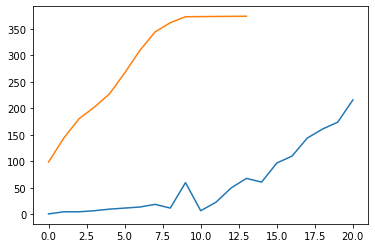

In [405]:
plt.plot(train_df.loc[(train_df.state == 'California') & 
             (train_df.date >= pd.to_datetime("2020-02-29")) & 
             (train_df.date < pd.to_datetime("2020-03-21")) &
             (train_df.date.dt.year == 2020)]['cases'].to_numpy())
plt.plot(predictions)

In [398]:
pd.to_datetime("2020-02-29")

Timestamp('2020-02-29 00:00:00')

In [279]:
train_df.loc[train_df['state'] == 'California'][25:50]

,state,date,cases,deaths,c1_school_closing,yesterdays_active_cases,pop_density,scaled_median_income,political_index
1251,California,2020-02-19,0.0,0.0,0.0,0.0,241.377092,0.715723,0.301093
1252,California,2020-02-20,1.0,0.0,0.0,0.0,241.377092,0.715723,0.301093
1253,California,2020-02-21,1.0,0.0,0.0,1.0,241.377092,0.715723,0.301093
1254,California,2020-02-22,0.0,0.0,0.0,1.0,241.377092,0.715723,0.301093
1255,California,2020-02-23,0.0,0.0,0.0,0.0,241.377092,0.715723,0.301093
1256,California,2020-02-24,2.0,0.0,0.0,0.0,241.377092,0.715723,0.301093
1257,California,2020-02-25,0.0,0.0,0.0,2.0,241.377092,0.715723,0.301093
1258,California,2020-02-26,15.0,0.0,0.0,0.0,241.377092,0.715723,0.301093
1259,California,2020-02-27,0.0,0.0,0.0,15.0,241.377092,0.715723,0.301093
1260,California,2020-02-28,1.0,0.0,0.0,0.0,241.377092,0.715723,0.301093


In [324]:
train_df['yesterdays_active_cases'].iloc[1268]

14.0

In [307]:
e_x_train_np[1205]

array([[  0.        ,   1.        , 241.37709154,   0.71572337,
          0.30109293],
       [  0.        ,   1.        , 241.37709154,   0.71572337,
          0.30109293],
       [  0.        ,   5.        , 241.37709154,   0.71572337,
          0.30109293],
       [  0.        ,   5.        , 241.37709154,   0.71572337,
          0.30109293],
       [  0.        ,   7.        , 241.37709154,   0.71572337,
          0.30109293],
       [  0.        ,  10.        , 241.37709154,   0.71572337,
          0.30109293],
       [  0.        ,  12.        , 241.37709154,   0.71572337,
          0.30109293]])

In [313]:
train_df[1268:(1268+14)]['c1_school_closing'].to_numpy()

array([1., 1., 1., 1., 1., 1., 2., 2., 2., 2., 3., 3., 3., 3.])

In [297]:
for i in range(len(e_x_train_np)):
    if e_x_train_np[i][0][-1] > .201093:
        print(i)
        print(e_x_train_np[i][0][-1])

1170
0.3010929306611844
1171
0.3010929306611844
1172
0.3010929306611844
1173
0.3010929306611844
1174
0.3010929306611844
1175
0.3010929306611844
1176
0.3010929306611844
1177
0.3010929306611844
1178
0.3010929306611844
1179
0.3010929306611844
1180
0.3010929306611844
1181
0.3010929306611844
1182
0.3010929306611844
1183
0.3010929306611844
1184
0.3010929306611844
1185
0.3010929306611844
1186
0.3010929306611844
1187
0.3010929306611844
1188
0.3010929306611844
1189
0.3010929306611844
1190
0.3010929306611844
1191
0.3010929306611844
1192
0.3010929306611844
1193
0.3010929306611844
1194
0.3010929306611844
1195
0.3010929306611844
1196
0.3010929306611844
1197
0.3010929306611844
1198
0.3010929306611844
1199
0.3010929306611844
1200
0.3010929306611844
1201
0.3010929306611844
1202
0.3010929306611844
1203
0.3010929306611844
1204
0.3010929306611844
1205
0.3010929306611844
1206
0.3010929306611844
1207
0.3010929306611844
1208
0.3010929306611844
1209
0.3010929306611844
1210
0.3010929306611844
1211
0.301092930

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/beau/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/backend.py", line 4232, in <genexpr>
    ta.write(time, out) for ta, out in zip(output_ta_t, flat_output))  File "/home/beau/anaconda3/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 235, in wrapped
    return _add_should_use_warning(fn(*args, **kwargs),
12868
0.2640751308410325
12869
0.2640751308410325
12870
0.2640751308410325
12871
0.2640751308410325
12872
0.2640751308410325
12873
0.2640751308410325
12874
0.2640751308410325
12875
0.2640751308410325
12876
0.2640751308410325
12877
0.2640751308410325
12878
0.2640751308410325
12879
0.2640751308410325
12880
0.2640751308410325
12881
0.2640751308410325
12882
0.2640751308410325
12883
0.2640751308410325


In [304]:
e_x_train_np[1207]

array([[  0.        ,   5.        , 241.37709154,   0.71572337,
          0.30109293],
       [  0.        ,   5.        , 241.37709154,   0.71572337,
          0.30109293],
       [  0.        ,   7.        , 241.37709154,   0.71572337,
          0.30109293],
       [  0.        ,  10.        , 241.37709154,   0.71572337,
          0.30109293],
       [  0.        ,  12.        , 241.37709154,   0.71572337,
          0.30109293],
       [  1.        ,  14.        , 241.37709154,   0.71572337,
          0.30109293],
       [  1.        ,  19.        , 241.37709154,   0.71572337,
          0.30109293]])

Shuffle training data before each epoch?
Reserve validation set for each epoch?
Set up hyperparameter tuning?
Setup simulation routine and predictions.
Save models?